<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/ViT_Grad_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install torch torchvision transformers matplotlib opencv-python


In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor


In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
def preprocess_image(image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

In [157]:
def generate_gradcam(model, image_tensor, target_class, device, mode="last"):  # mode="multi" or "last"
    """
    Generate Grad-CAM using either:
    - multi-layer averaged attention (mode="multi")
    - last-layer attention (mode="last")
    """
    model.eval()

    with torch.no_grad():
        outputs = model.vit(pixel_values=image_tensor, output_attentions=True)
        all_attentions = outputs.attentions  # list of attention maps from each layer

    if mode == "multi":
        # Average across all layers and heads
        stacked_attn = torch.stack(all_attentions)  # (layers, batch, heads, seq_len, seq_len)
        mean_attn = stacked_attn.mean(dim=[0, 2])   # mean over layers & heads -> (batch, seq_len, seq_len)
        attn_map = mean_attn[0].cpu().numpy()       # for first image in batch

    elif mode == "last":
        # Use last layer's attention only
        attn = all_attentions[-1]                   # last layer: (batch, heads, seq_len, seq_len)
        attn_map = attn.mean(dim=1)[0].cpu().numpy()# average over heads

    else:
        raise ValueError("Invalid mode. Use 'multi' or 'last'")

    # Extract CLS attention to patch tokens
    attn_patch = attn_map[0, 1:]
    cam = attn_patch.reshape(14, 14)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam


In [158]:
def overlay_heatmap(image_path, cam):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.show()


In [159]:
# Load saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load("/content/drive/MyDrive/VIT_model.pth", map_location=device))
model.to(device)
model.eval()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [160]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [161]:
image_path = "/content/drive/MyDrive/Dataset4/Training/Real/2000_s9.jpg"  # Replace with your own
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=image_tensor).logits
    pred = torch.argmax(outputs, dim=1).item()

print(f"Predicted Class: {'Real' if pred == 1 else 'Fake'}")


Predicted Class: Real


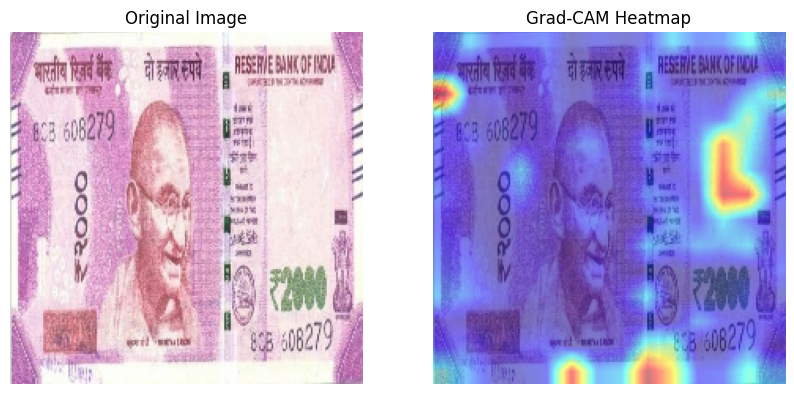

In [162]:
# Example usage
image_path = "/content/drive/MyDrive/Dataset4/Training/Real/2000_s9.jpg"  # Replace with an actual image path
image_tensor = preprocess_image(image_path, transform, device)
pred = model(pixel_values=image_tensor).logits.argmax().item()
cam = generate_gradcam(model, image_tensor, pred, device)
overlay_heatmap(image_path, cam)
